# Chapter 2 - Exploratory Data Analysis

## Import Necessary Libraries

In [1]:
from pyspark.sql import SparkSession
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

## Initialize SparkSession and Connection to MySQL Server

In [2]:
# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Exploratory Data Analysis") \
    .config("spark.some.config.option", "some-value") \
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:2.7.0,mysql:mysql-connector-java:8.0.17") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()

# MySQL connection
jdbc_url = "jdbc:mysql://localhost:3306/HomeLoans?serverTimezone=UTC"
connection_properties = {
    "user": "root",
    "password": "mypass",
    "driver": "com.mysql.cj.jdbc.Driver"
}


## Load all Needed Data to Dataframes

In [3]:
df_train = spark.read.jdbc(url=jdbc_url, table="applicationtrain", properties=connection_properties)
df_test = spark.read.jdbc(url=jdbc_url, table="applicationtest", properties=connection_properties)
df_bureau = spark.read.jdbc(url=jdbc_url, table="bureau", properties=connection_properties)
df_bureau_balance = spark.read.jdbc(url=jdbc_url, table="bureau_balance", properties=connection_properties)
df_credit_card_balance = spark.read.jdbc(url=jdbc_url, table="credit_card_balance", properties=connection_properties)
df_installments_payments = spark.read.jdbc(url=jdbc_url, table="installments_payments", properties=connection_properties)
df_pos_cash_balance = spark.read.jdbc(url=jdbc_url, table="pos_cash_balance", properties=connection_properties)
df_previous_application = spark.read.jdbc(url=jdbc_url, table="previous_application", properties=connection_properties)
df_column_desc= spark.read.jdbc(url=jdbc_url, table="homecredit_columns_description", properties=connection_properties)




## View Sample Data and Print their Schema

In [5]:
df_column_desc.show(10)
df_train.show(10)
df_train.printSchema()

target_counts = df_train.groupBy('TARGET').count()
target_counts.show()

+---------------+--------------------+------------------+--------------------+-------+
|MyUnknownColumn|               Table|               Row|         Description|Special|
+---------------+--------------------+------------------+--------------------+-------+
|              1|application_{trai...|        SK_ID_CURR|ID of loan in our...|       |
|              2|application_{trai...|            TARGET|Target variable (...|       |
|              5|application_{trai...|NAME_CONTRACT_TYPE|Identification if...|       |
|              6|application_{trai...|       CODE_GENDER|Gender of the client|       |
|              7|application_{trai...|      FLAG_OWN_CAR|Flag if the clien...|       |
|              8|application_{trai...|   FLAG_OWN_REALTY|Flag if client ow...|       |
|              9|application_{trai...|      CNT_CHILDREN|Number of childre...|       |
|             10|application_{trai...|  AMT_INCOME_TOTAL|Income of the client|       |
|             11|application_{trai...|     

## View Data for Outlier Detection and General Data Anomalies

In [5]:
df_train.describe().show()
# CNT_CHILDREN = 19 
# Days_employed = 365243 -> 1000 years of employment.
# CNT_FAM_MEMBERS = 20 
# Most Loans are given on Emergency.

+-------+------------------+-------------------+------------------+-----------+------------+---------------+------------------+-----------------+-----------------+------------------+------------------+---------------+----------------+--------------------+------------------+-----------------+--------------------------+-------------------+------------------+------------------+-------------------+------------------+--------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+------------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+--------------------+--------------------+--------------------+-------------------+-------------------+---------------------------+-------------------+----

## Spark Dataframe Convertion to Pandas Dataframe For Visualization

In [6]:
df_train_pandas = df_train.toPandas()
df_bureau_pandas = df_bureau.toPandas()
df_previous_application_pandas = df_previous_application.toPandas()

## Family Status

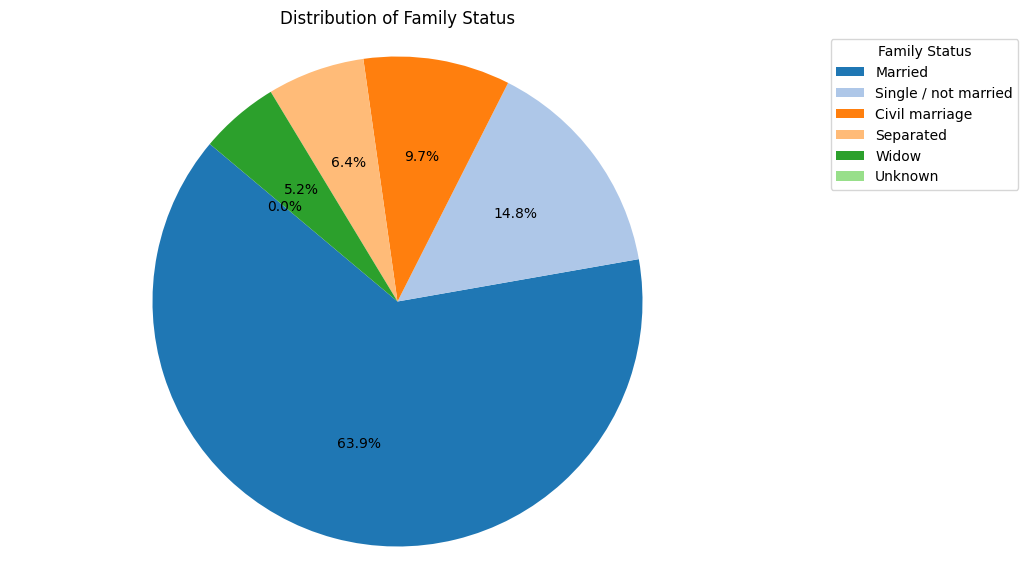

In [7]:
family_status_counts = df_train_pandas['NAME_FAMILY_STATUS'].value_counts()

plt.figure(figsize=(10, 7))
colors = plt.get_cmap('tab20').colors  
plt.pie(family_status_counts, labels=None, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Distribution of Family Status')
plt.axis('equal') 
plt.legend(family_status_counts.index, title='Family Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Age Distribution in Taking Loans

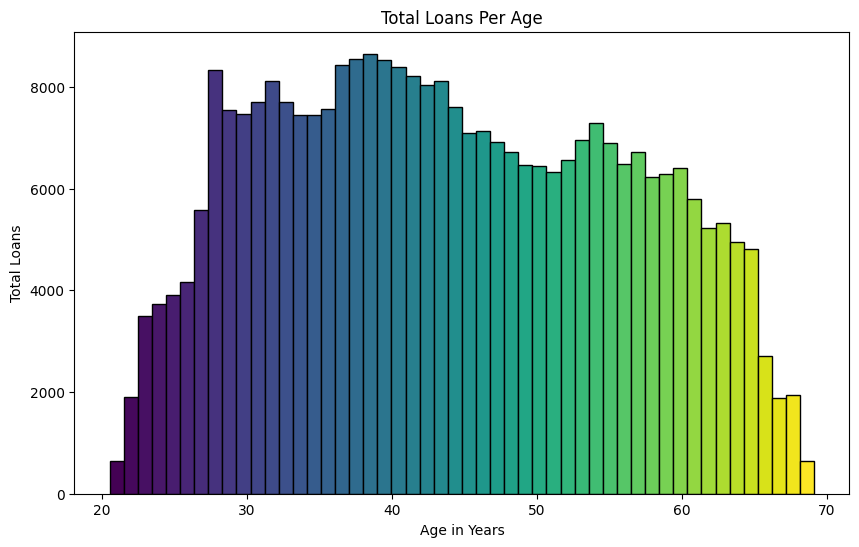

In [8]:
df_train_pandas['AGE_YEARS'] = df_train_pandas['DAYS_BIRTH'] / -365

# Set up the colormap
cmap = cm.get_cmap('viridis')

# Applying Color Gradient 
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_train_pandas['AGE_YEARS'], bins=50, edgecolor='black')

# Color normalization using Bin 
bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap(c))

plt.title('Total Loans Per Age')
plt.xlabel('Age in Years')
plt.ylabel('Total Loans')
plt.show()

## Age Distribution By Loan Status
Target = 1 -> Client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan.<br>
Target = 0 -> All Other Cases.

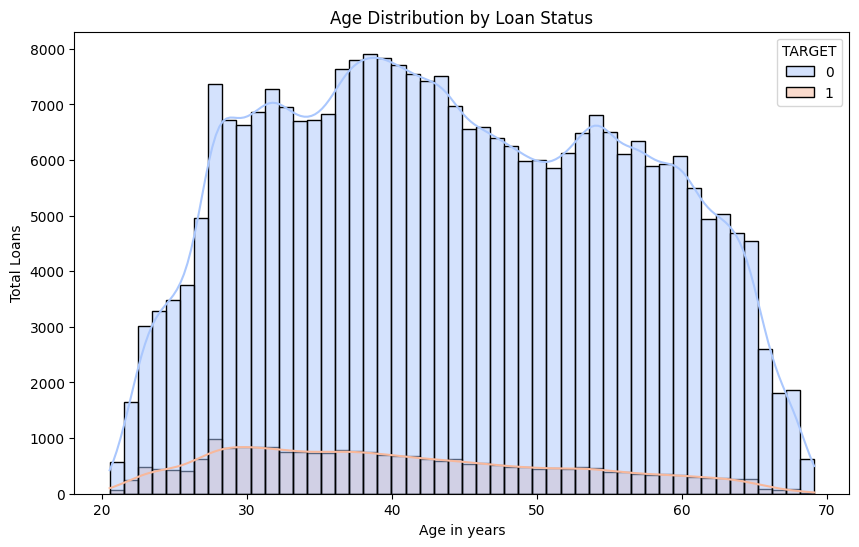

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_train_pandas, x='AGE_YEARS', hue='TARGET', bins=50, kde=True, palette='coolwarm')
plt.title('Age Distribution by Loan Status')
plt.xlabel('Age in years')
plt.ylabel('Total Loans')
plt.show()

## Income and Age relation

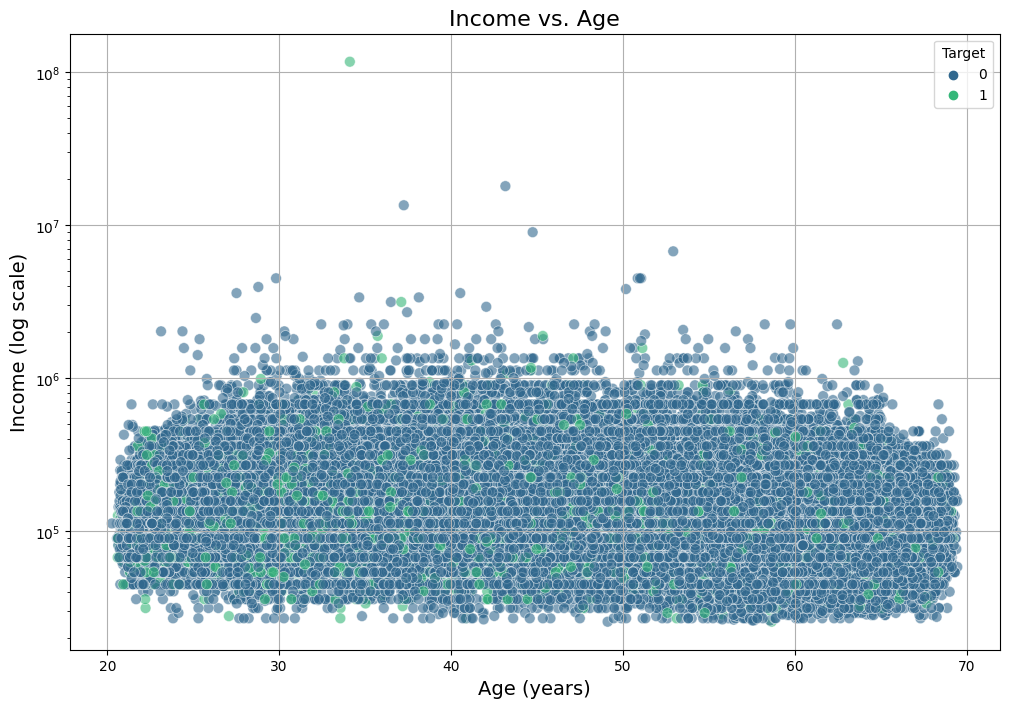

In [10]:
jitter = np.random.uniform(-1, 1, size=df_train_pandas.shape[0])
df_train_pandas['AGE_YEARS_JITTER'] = df_train_pandas['AGE_YEARS'] + jitter * 0.5  

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_train_pandas, x='AGE_YEARS_JITTER', y='AMT_INCOME_TOTAL', hue='TARGET', palette='viridis', alpha=0.6, s=60, edgecolor='w', linewidth=0.5)
plt.yscale('log')
plt.title('Income vs. Age', fontsize=16)
plt.xlabel('Age (years)', fontsize=14)
plt.ylabel('Income (log scale)', fontsize=14)
plt.legend(title='Target', loc='upper right')
plt.grid(True)
plt.show()

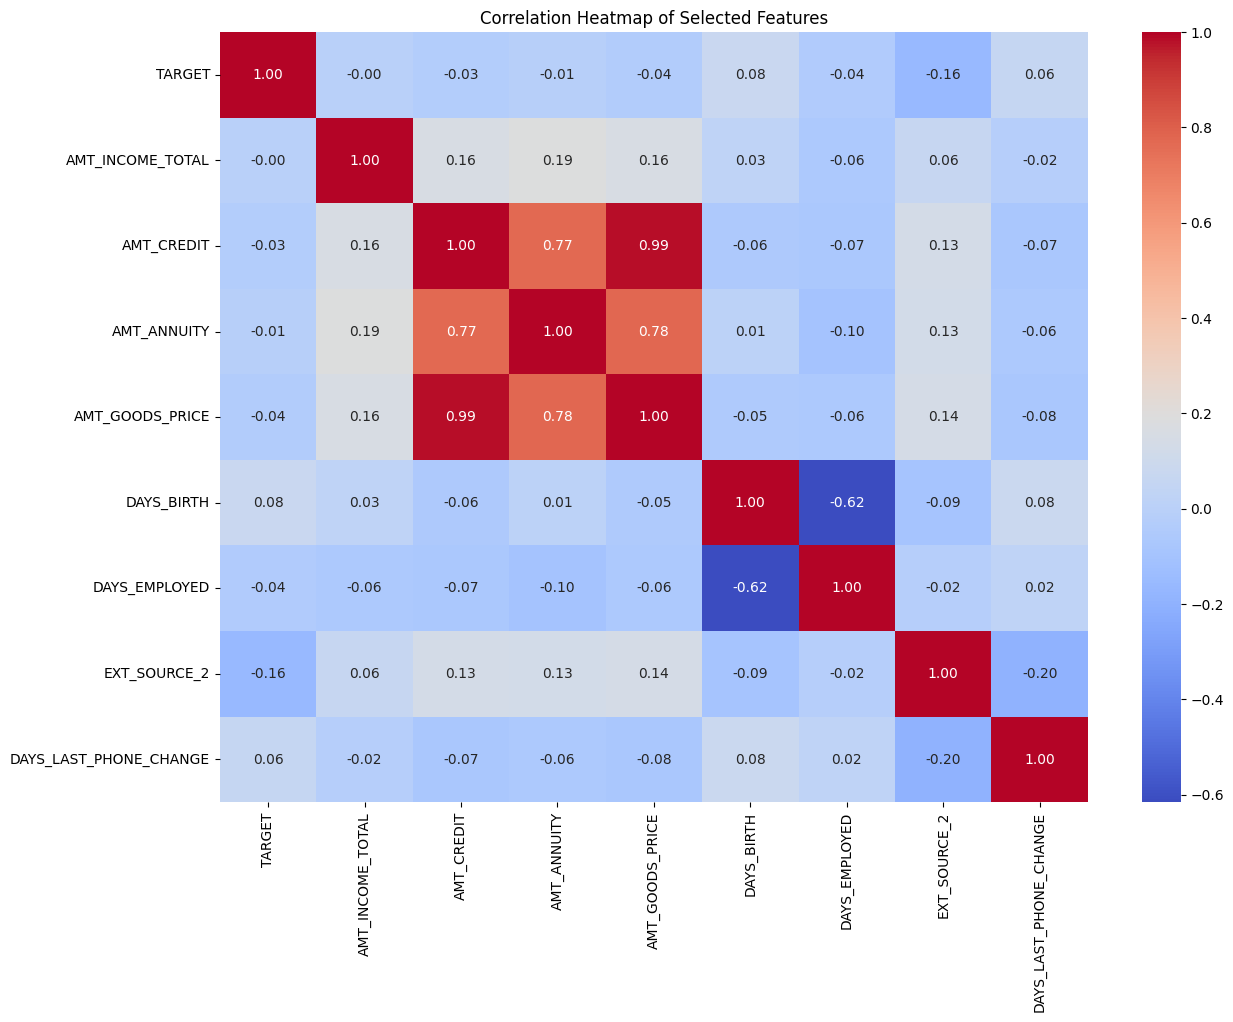

In [11]:
selected_features = [
    'TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
    'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_YEAR'
]

corr_matrix = df_train_pandas[selected_features].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Selected Features')
plt.show()

## Loan Amount Distribution
Most loans are between 10.000 and 800.000 

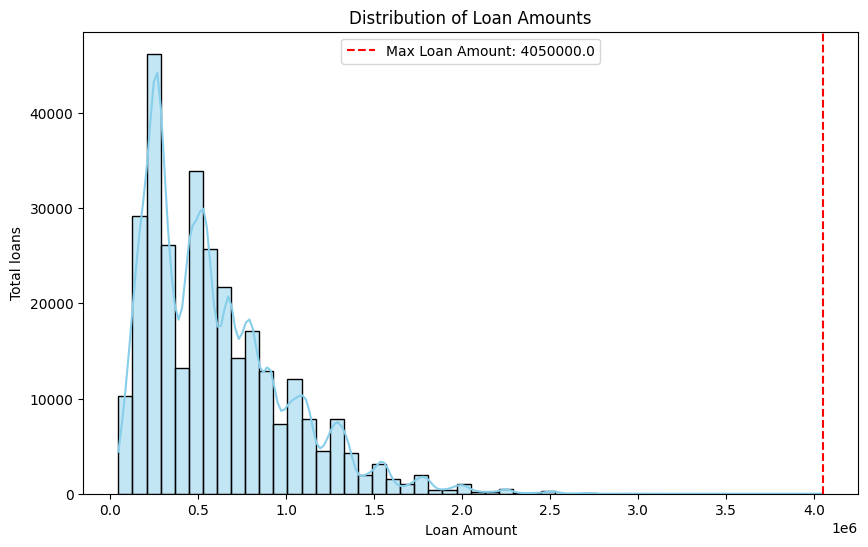

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train_pandas['AMT_CREDIT'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Loan Amounts')
plt.xlabel('Loan Amount')
plt.ylabel('Total loans')


max_loan_amount = df_train_pandas['AMT_CREDIT'].max()

plt.axvline(x=max_loan_amount, color='red', linestyle='--', label=f'Max Loan Amount: {max_loan_amount}')
plt.legend()

plt.show()

## Distribution of Contract Types and Income Types

Most Loans are Cash Loans outnumbering Revolving loans by far. <br>
Viral income types include Working income, Commercial Association and Pensioner

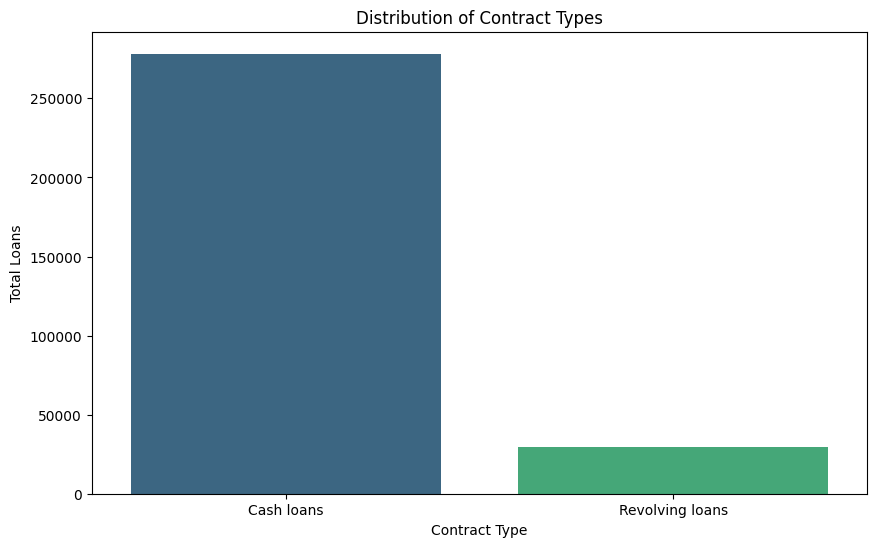

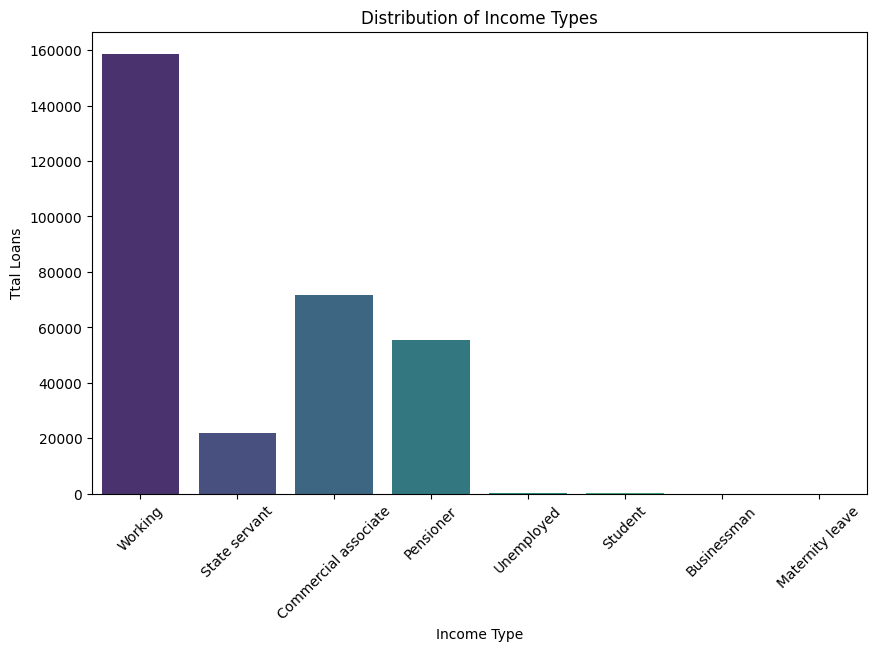

In [13]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train_pandas, x='NAME_CONTRACT_TYPE', palette='viridis')
plt.title('Distribution of Contract Types')
plt.xlabel('Contract Type')
plt.ylabel('Total Loans')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df_train_pandas, x='NAME_INCOME_TYPE', palette='viridis')
plt.title('Distribution of Income Types')
plt.xlabel('Income Type')
plt.ylabel('Ttal Loans')
plt.xticks(rotation=45)
plt.show()

## Distribution of Number of Children By Target
the Y axis is in LOG since values with children over 8 were not possible to be viewed.

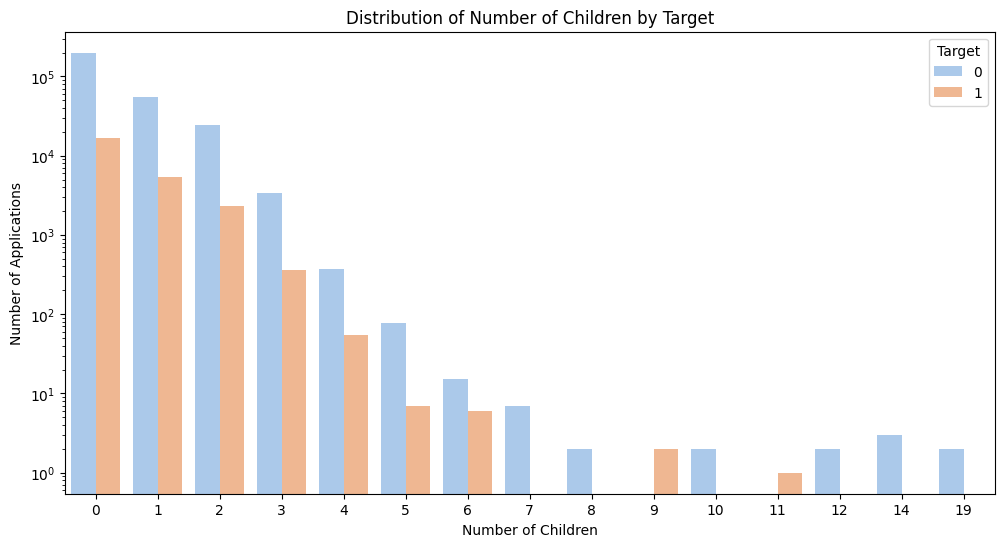

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train_pandas, x='CNT_CHILDREN', hue='TARGET', palette='pastel')
plt.title('Distribution of Number of Children by Target')
plt.xlabel('Number of Children')
plt.ylabel('Number of Applications')
plt.legend(title='Target', loc='upper right')
plt.yscale('log')
plt.show()

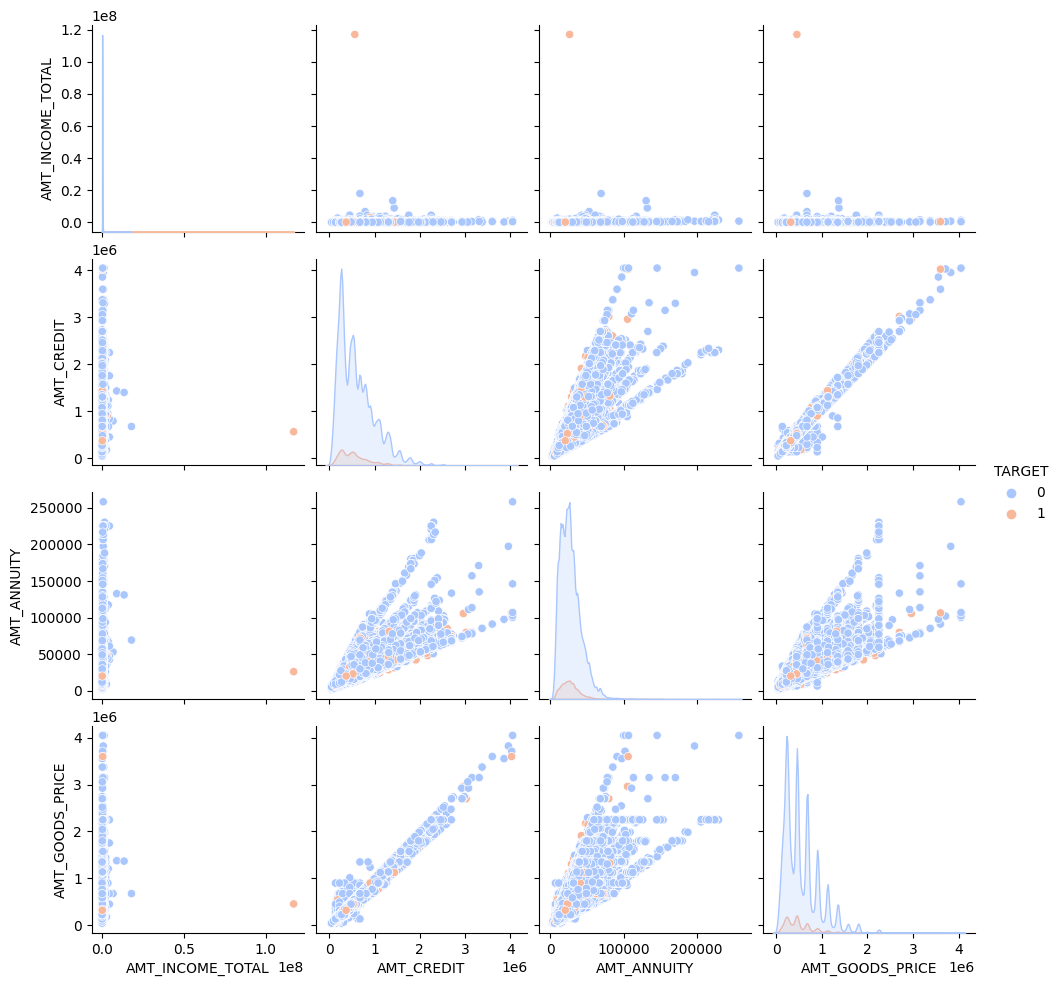

In [15]:
features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'TARGET']
df_pairplot = df_train.select(features).toPandas()

# create the pairplot for specific Features.
sns.pairplot(df_pairplot, hue='TARGET', palette='coolwarm', diag_kind='kde')
plt.show()

# Income Distribution By Gender

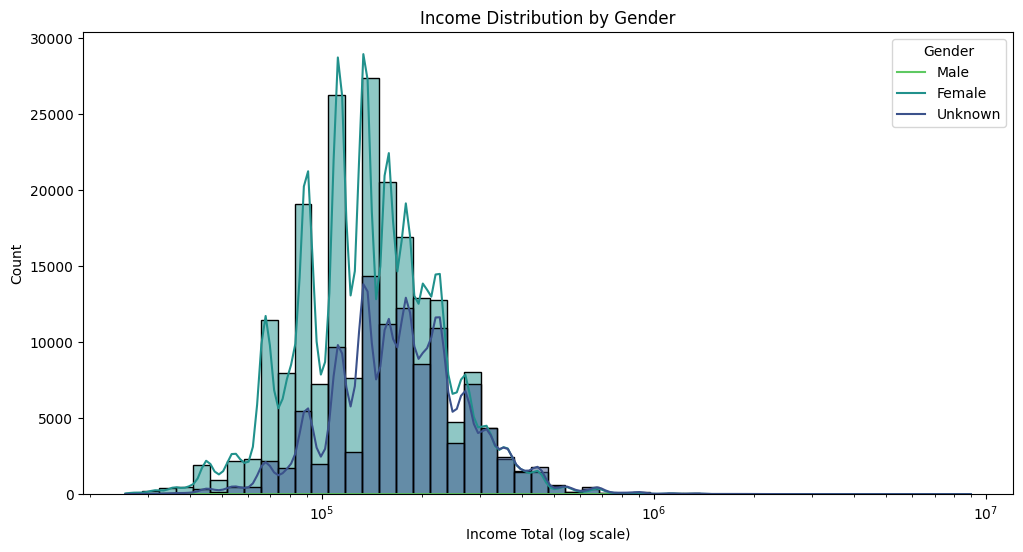

In [16]:
plt.figure(figsize=(12, 6))
# Applying a logarithmic scale to the x-axis.
sns.histplot(data=df_train_pandas[df_train_pandas['AMT_INCOME_TOTAL'] < 1e7], x='AMT_INCOME_TOTAL', hue='CODE_GENDER', bins=50, kde=True, palette='viridis', log_scale=(True, False))
plt.title('Income Distribution by Gender')
plt.xlabel('Income Total (log scale)')
plt.ylabel('Count')
plt.legend(title='Gender', loc='upper right', labels=['Male', 'Female', 'Unknown'])
plt.show()

## Borrower Car and Realty Ownership vs Repayment Difficulties

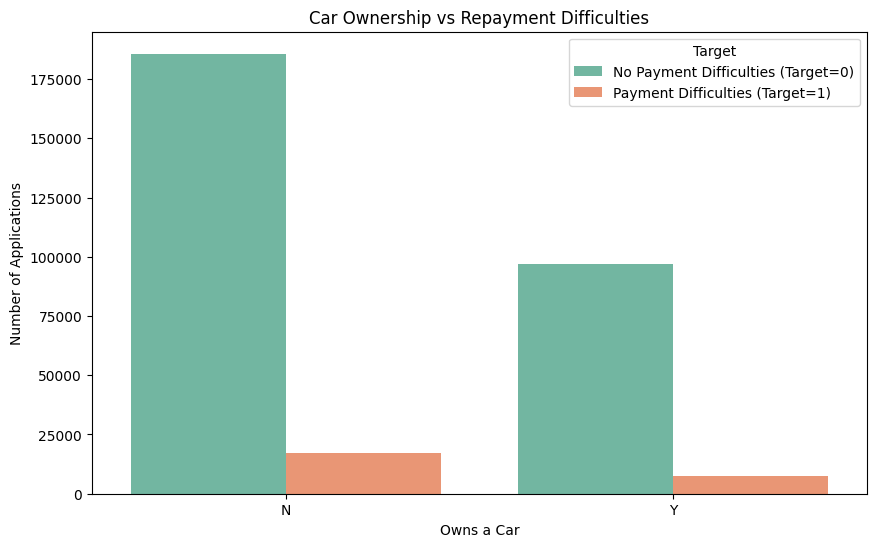

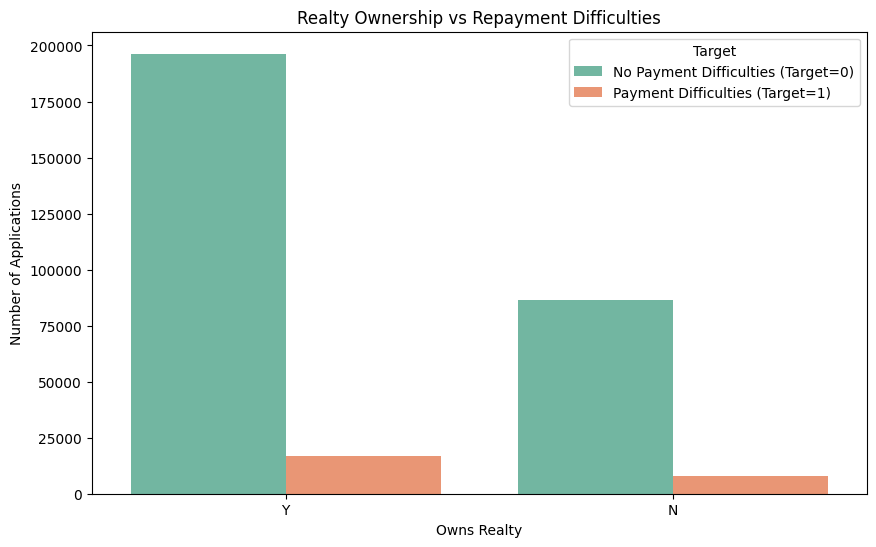

In [17]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_train_pandas, x='FLAG_OWN_CAR', hue='TARGET', palette='Set2')
plt.title('Car Ownership vs Repayment Difficulties')
plt.xlabel('Owns a Car')
plt.ylabel('Number of Applications')
plt.legend(title='Target', loc='upper right', labels=['No Payment Difficulties (Target=0)', 'Payment Difficulties (Target=1)'])
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df_train_pandas, x='FLAG_OWN_REALTY', hue='TARGET', palette='Set2')
plt.title('Realty Ownership vs Repayment Difficulties')
plt.xlabel('Owns Realty')
plt.ylabel('Number of Applications')
plt.legend(title='Target', loc='upper right', labels=['No Payment Difficulties (Target=0)', 'Payment Difficulties (Target=1)'])
plt.show()

## Documents importance in Loan Application
Seems that the most important document is Document_3 followed by Document_6 and Document_8

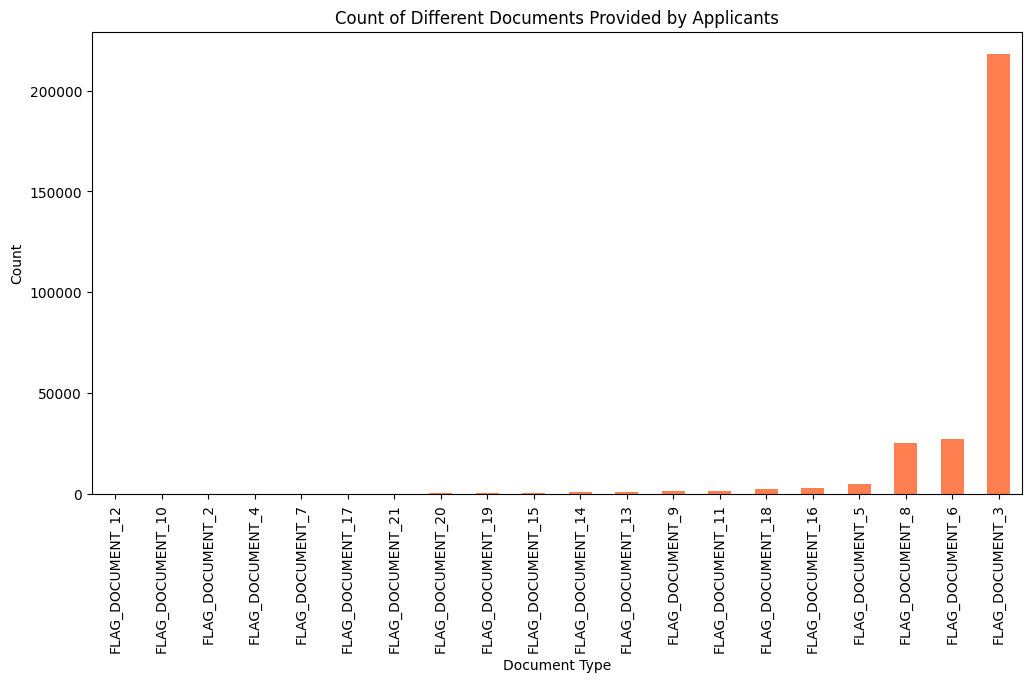

In [18]:
document_columns = [col for col in df_train_pandas.columns if col.startswith('FLAG_DOCUMENT')]
document_counts = df_train_pandas[document_columns].sum().sort_values()

plt.figure(figsize=(12, 6))
document_counts.plot(kind='bar', color='coral')
plt.title('Count of Different Documents Provided by Applicants')
plt.xlabel('Document Type')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# -----------------------------------
# Bureau Data
# -----------------------------------

##  Days Before Client Apply for Credit Bureau credit before his Current Application

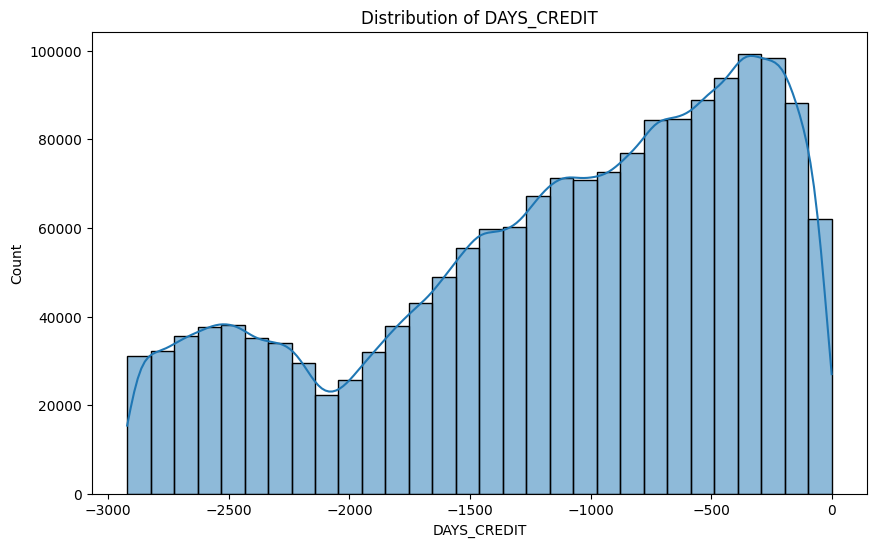

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(df_bureau_pandas['DAYS_CREDIT'].dropna(), kde=True, bins=30)
plt.title('Distribution of DAYS_CREDIT')
plt.xlabel('DAYS_CREDIT')
plt.ylabel('Count')
plt.show()

## Status of Loan Applications Submitted in Bureau

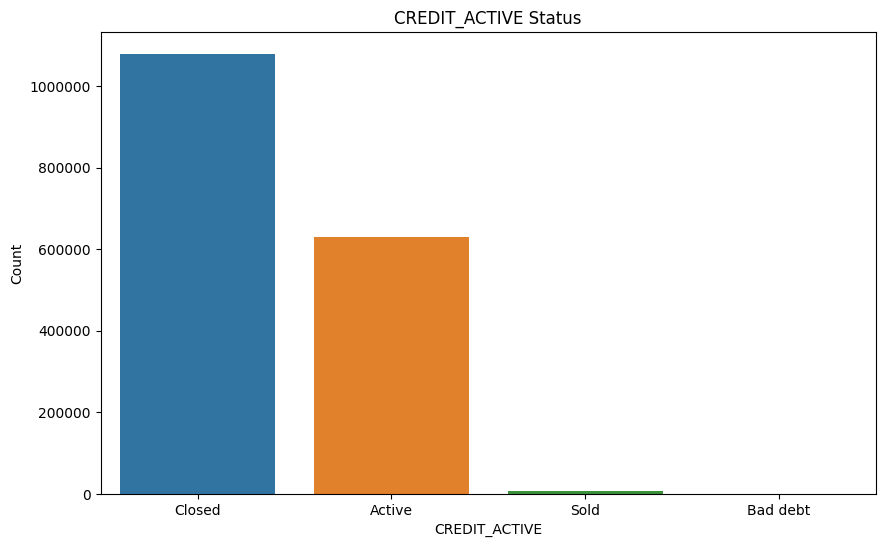

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='CREDIT_ACTIVE', data=df_bureau_pandas)
plt.title('CREDIT_ACTIVE Status')
plt.xlabel('CREDIT_ACTIVE')
plt.ylabel('Count')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

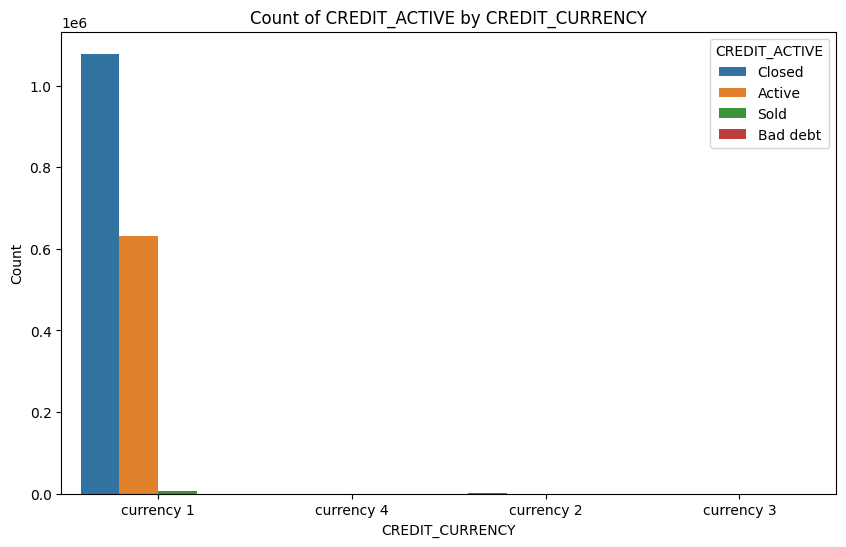

In [21]:
plt.figure(figsize=(10, 6))
sns.countplot(x='CREDIT_CURRENCY', hue='CREDIT_ACTIVE', data=df_bureau_pandas)
plt.title('Count of CREDIT_ACTIVE by CREDIT_CURRENCY')
plt.xlabel('CREDIT_CURRENCY')
plt.ylabel('Count')
plt.show()

## Reason For Loans

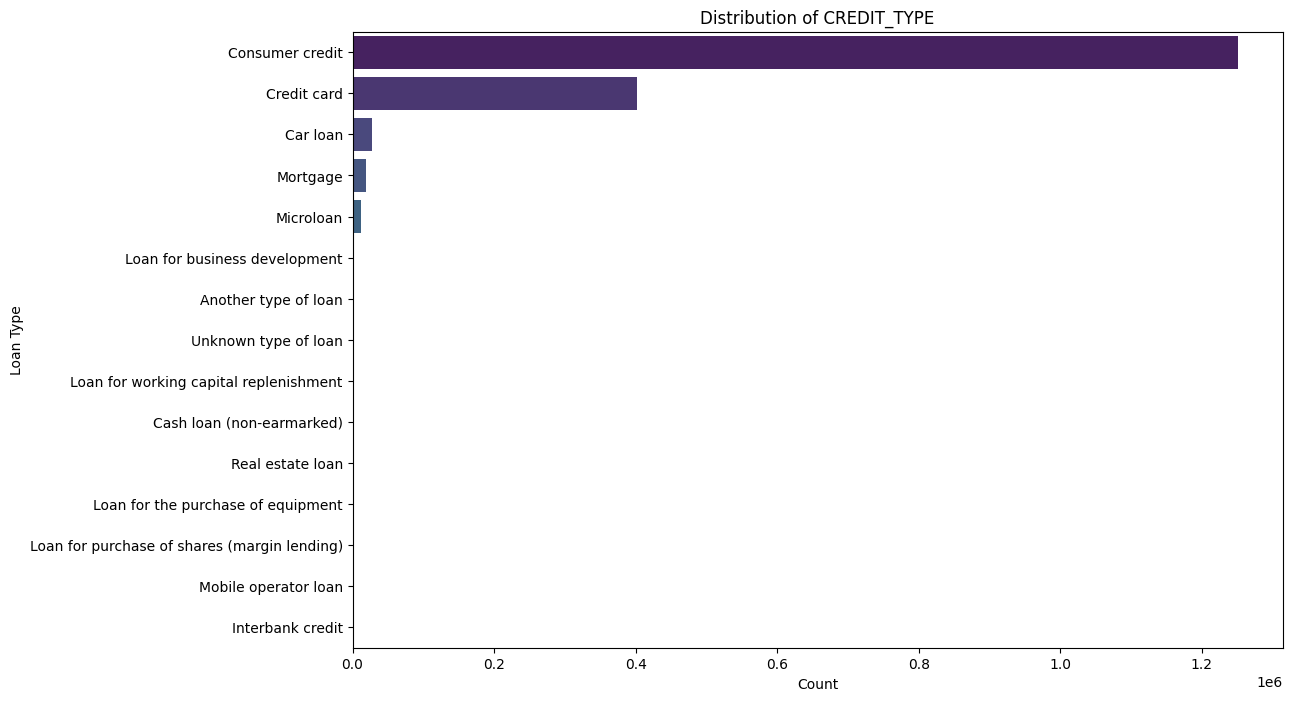

In [22]:
credit_type_counts = df_bureau_pandas['CREDIT_TYPE'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(y=credit_type_counts.index, x=credit_type_counts.values, palette='viridis')
plt.title('Distribution of CREDIT_TYPE')
plt.xlabel('Count')
plt.ylabel('Loan Type')
plt.show()

## Detect Outliers Using a WorldWide Function
It can be seen that there are some peaks in the dataset showing that there are outliers

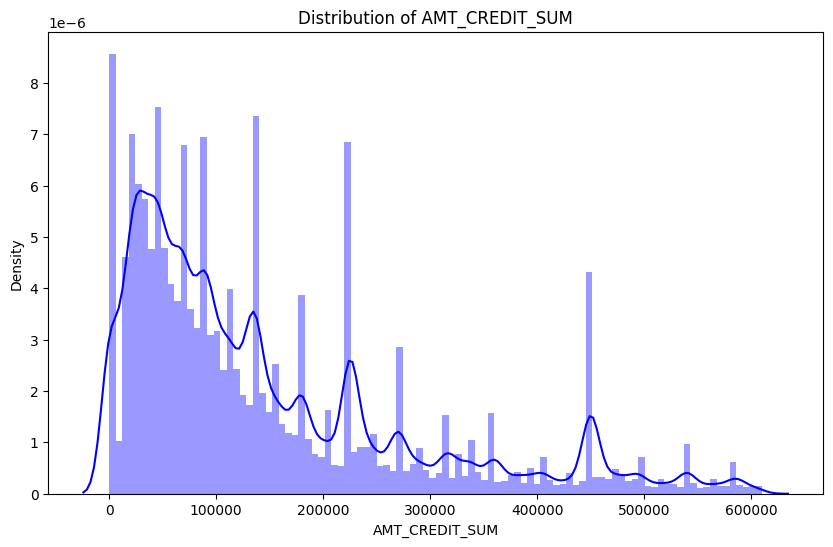

In [23]:
# Source: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting (see references)

def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def plot_b_o_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    x = df_bureau_pandas[feature].dropna()
    filtered = x[~is_outlier(x)]
    sns.distplot(filtered,color=color, kde=True,bins=100)
    plt.show() 

plot_b_o_distribution('AMT_CREDIT_SUM','blue')

# -----------------------------------
# Previous Application Data
# -----------------------------------

## Contract Type

XNA - Not Available<br>
XAP - Not Applicable

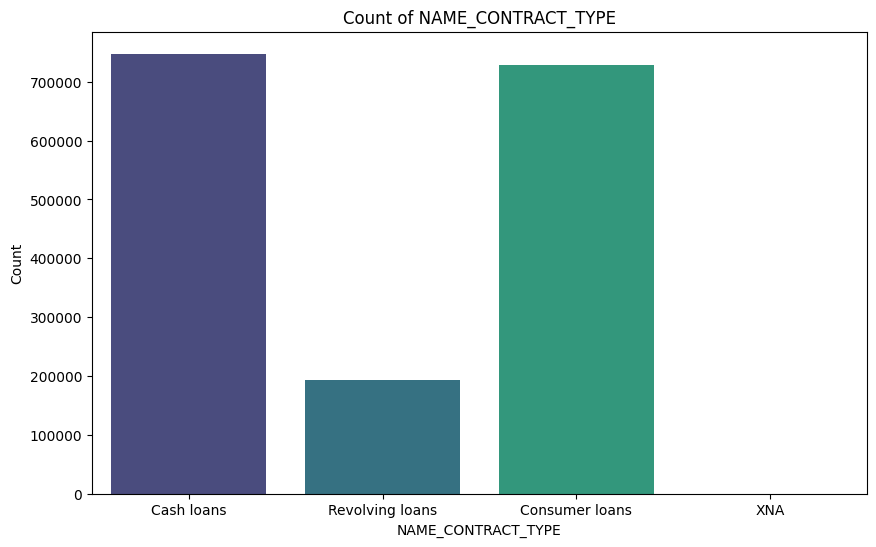

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(x='NAME_CONTRACT_TYPE', data=df_previous_application_pandas, palette='viridis')
plt.title('Count of NAME_CONTRACT_TYPE')
plt.xlabel('NAME_CONTRACT_TYPE')
plt.ylabel('Count')
plt.show()

## Reason for Taking the Loan

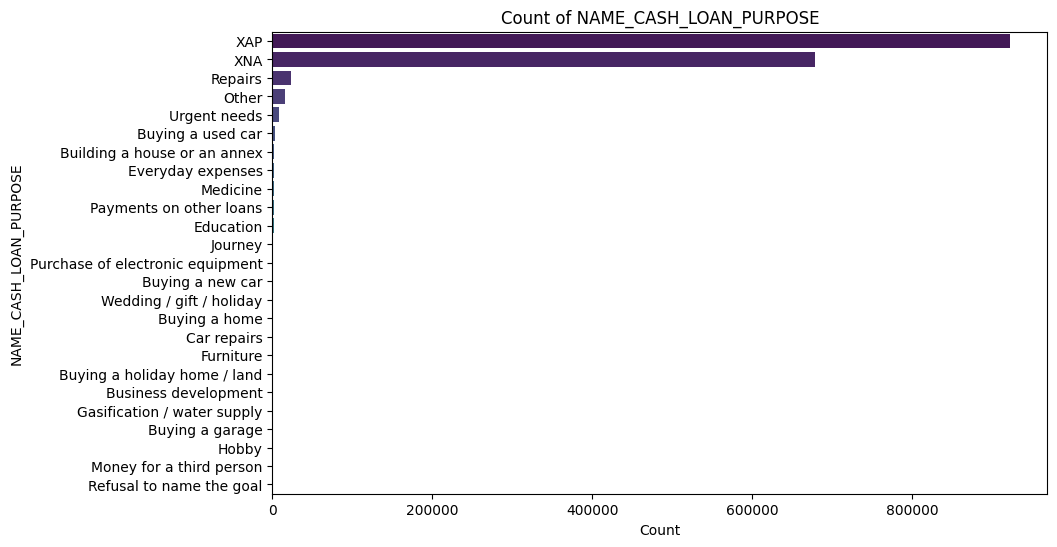

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(y='NAME_CASH_LOAN_PURPOSE', data=df_previous_application_pandas, order=df_previous_application_pandas['NAME_CASH_LOAN_PURPOSE'].value_counts().index, palette='viridis')
plt.title('Count of NAME_CASH_LOAN_PURPOSE')
plt.xlabel('Count')
plt.ylabel('NAME_CASH_LOAN_PURPOSE')
plt.show()


# Days Up to when the Decision Was taken for Previous Applications to Current Application

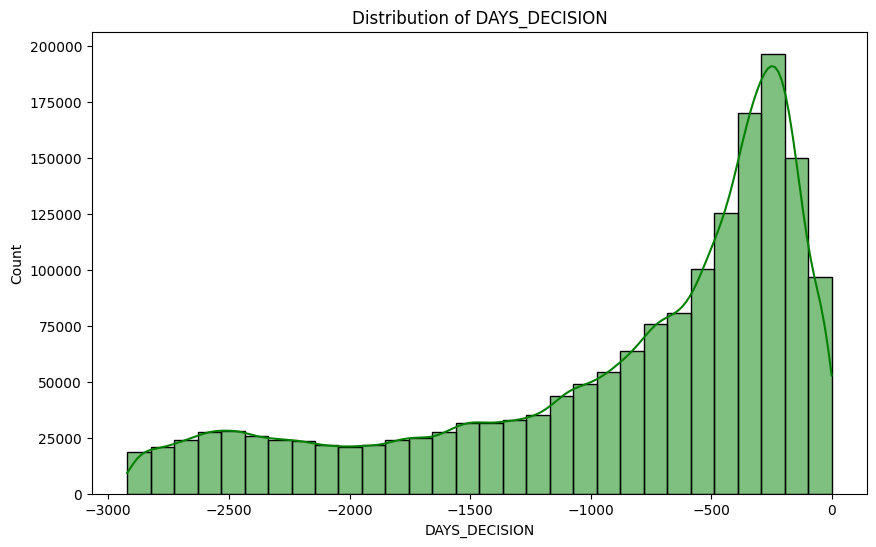

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(df_previous_application_pandas['DAYS_DECISION'].dropna(), kde=True, bins=30, color='green')
plt.title('Distribution of DAYS_DECISION')
plt.xlabel('DAYS_DECISION')
plt.ylabel('Count')
plt.show()

## NEXT CHAPTER -> FEATURE ENGINEERING
- Handling Missing Values
- Encode Categorical Variables
- Scale Features
- Create Aggregated Features for model enhancement